In [1]:
import hamiltonianMonteCarlo as hmc
from constrained_gpr import ConstrainedGaussianProcess
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
import scipy



# Implementation of the Basis Functions for Multi-dimensions

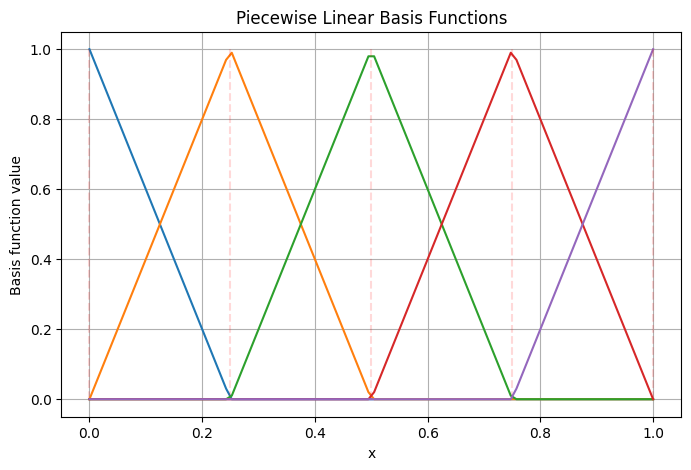

In [2]:
from basis_functions import BasisFunctions as bf

basis = bf(m= 5)
basis.plot_basis_functions(dim=0)

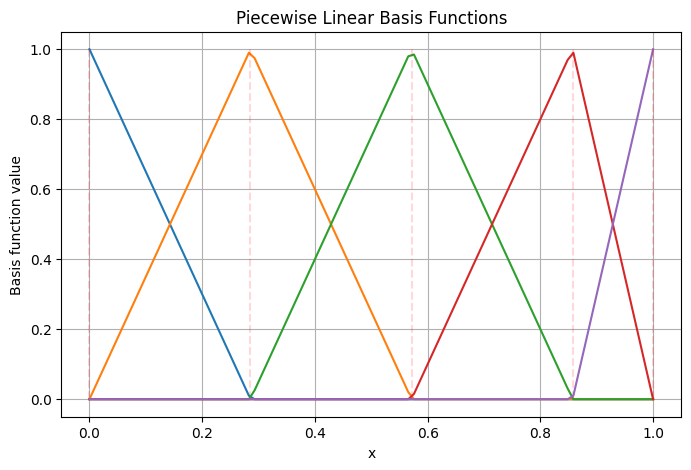

In [3]:
from basis_functions import BasisFunctions as bf

basis = bf(delta_m = 2/7)
basis.plot_basis_functions(dim=0)

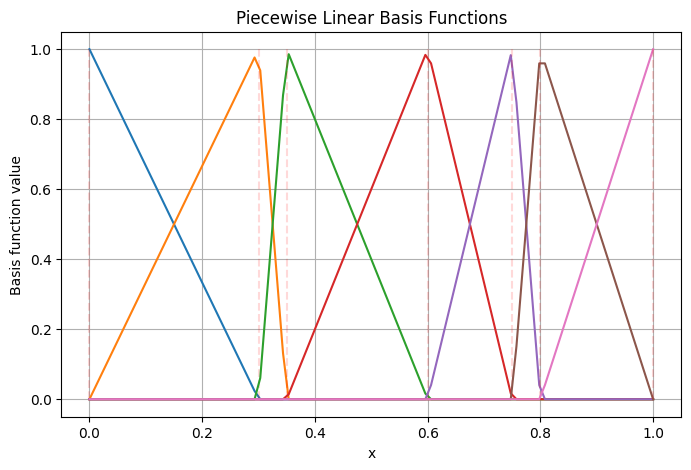

In [4]:
from basis_functions import BasisFunctions as bf

basis = bf(knots = [0,0.3,0.35,0.6,0.75,0.8,1])
basis.plot_basis_functions(dim=0)

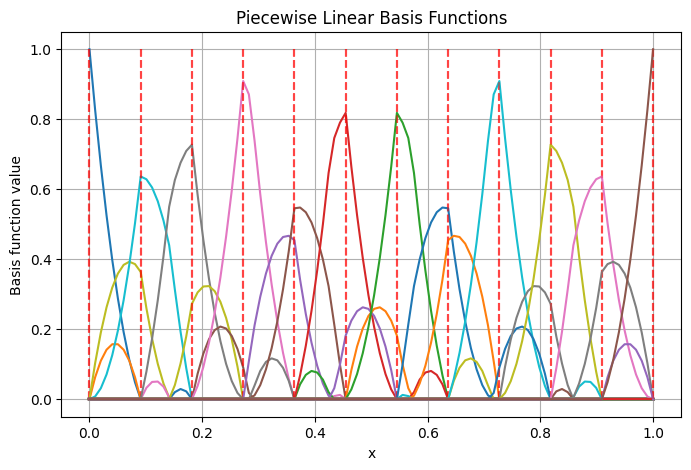

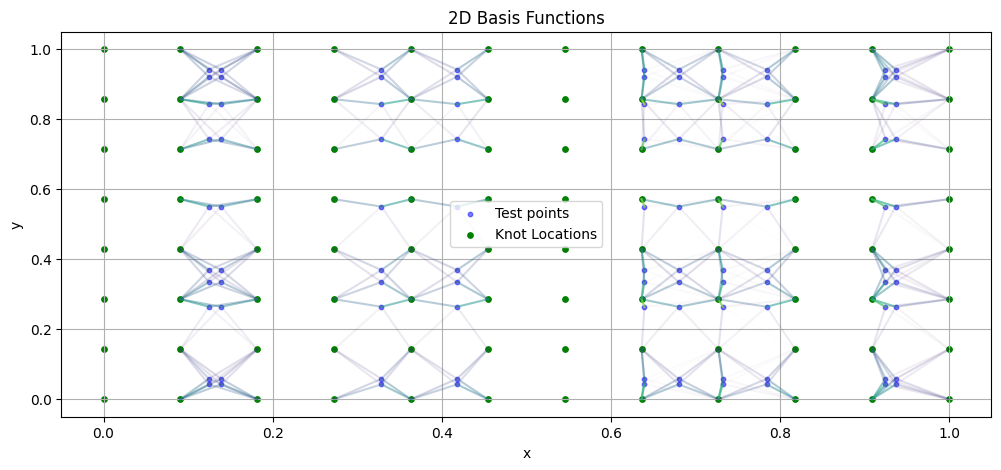

In [5]:
from basis_functions import BasisFunctions as bf

basis = bf(m = [12, 8])
basis.plot_basis_functions(dim=0)
basis.plot_basis_functions_2d()

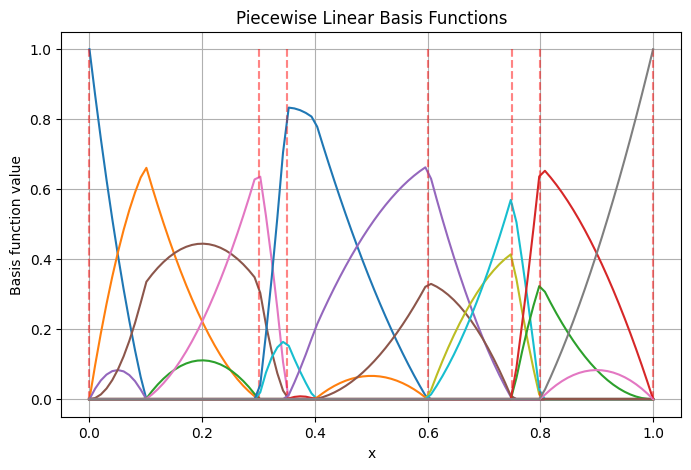

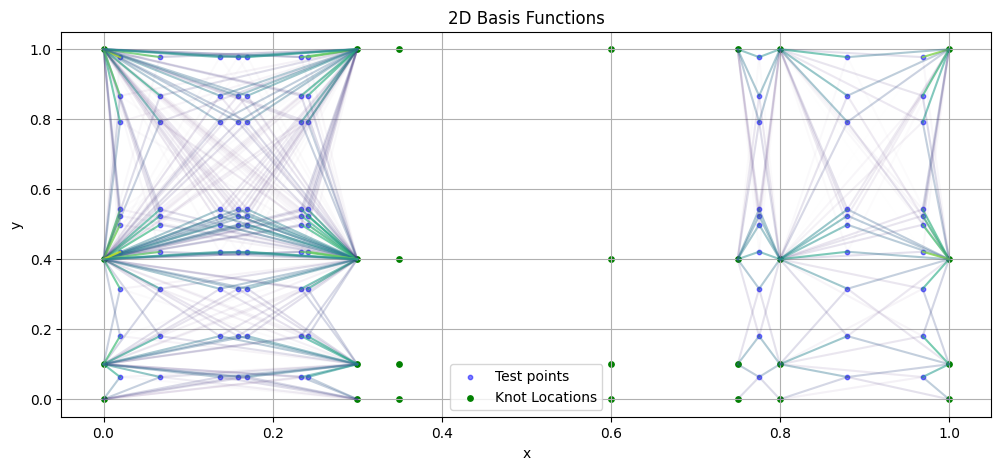

In [6]:
from basis_functions import BasisFunctions as bf

basis = bf(knots = [[0,0.3,0.35,0.6,0.75,0.8,1], [0,0.1,0.4,1]])
basis.plot_basis_functions(dim=0)
basis.plot_basis_functions_2d()

# Implementation of Constrained GP

Iter 100/500 - Loss: 0.307
  lengthscale: 0.605
  outputscale: 2.898
Iter 200/500 - Loss: 0.306
  lengthscale: 0.639
  outputscale: 3.504
Iter 300/500 - Loss: 0.306
  lengthscale: 0.651
  outputscale: 3.736
Iter 400/500 - Loss: 0.306
  lengthscale: 0.655
  outputscale: 3.818
Iter 500/500 - Loss: 0.306
  lengthscale: 0.656
  outputscale: 3.841


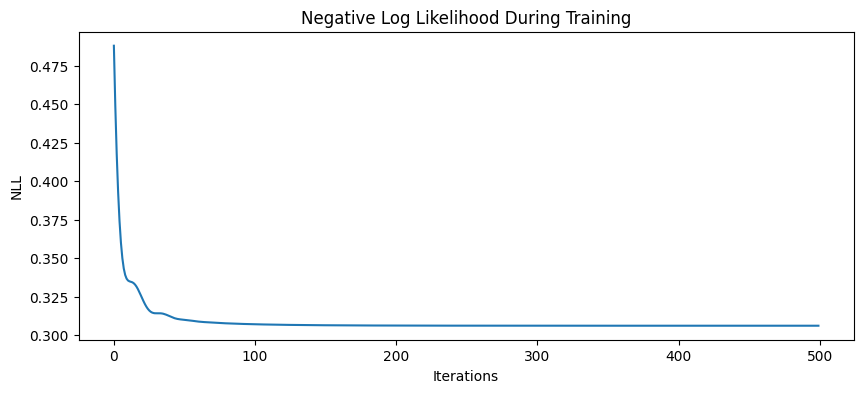

C:\Users\Emre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


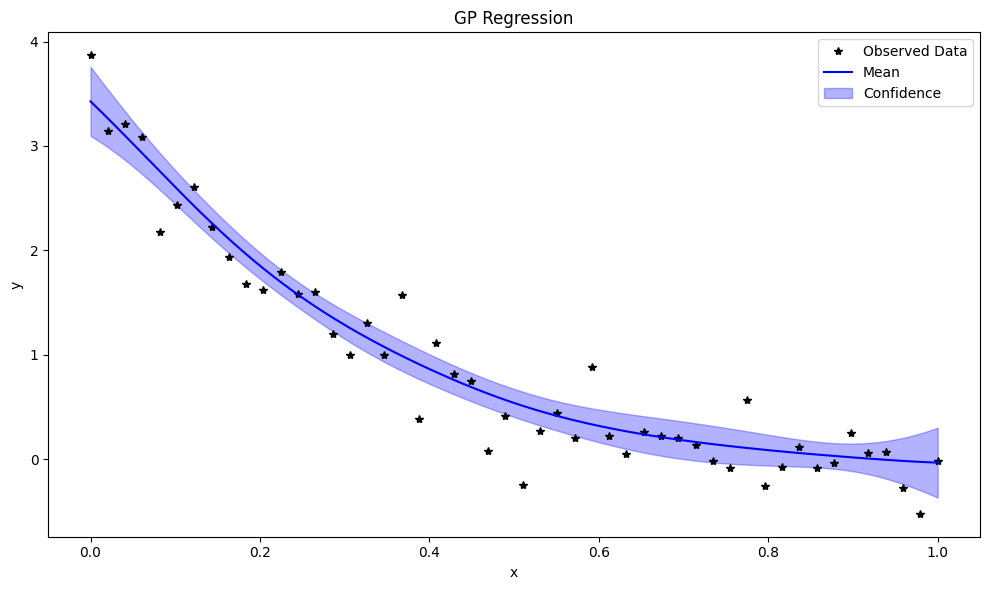

Final lengthscale: 0.6564
Final outputscale: 3.8412


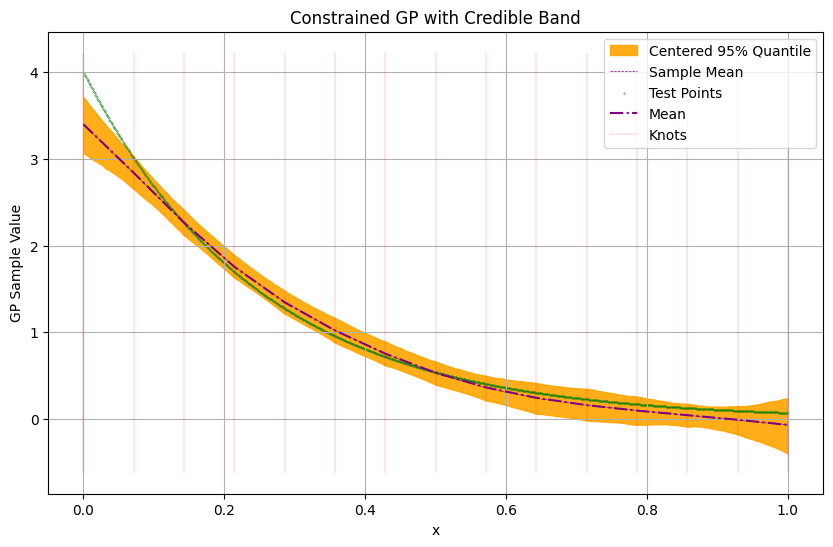

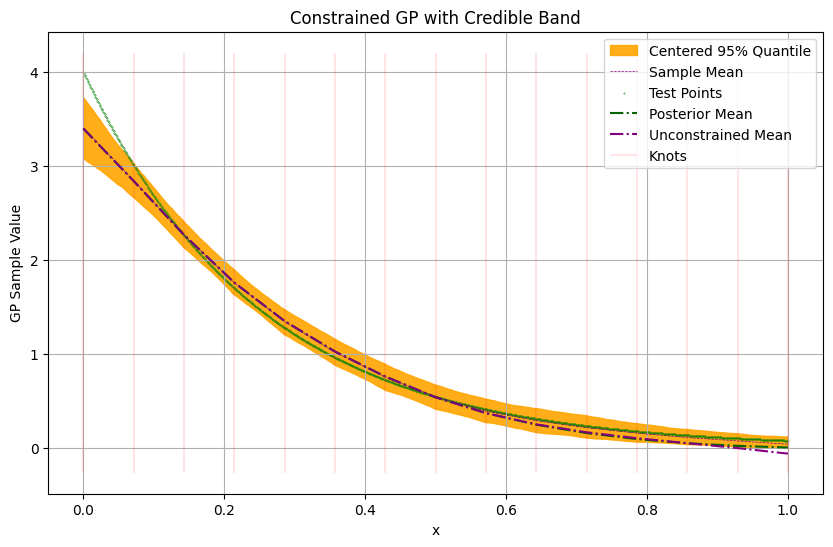

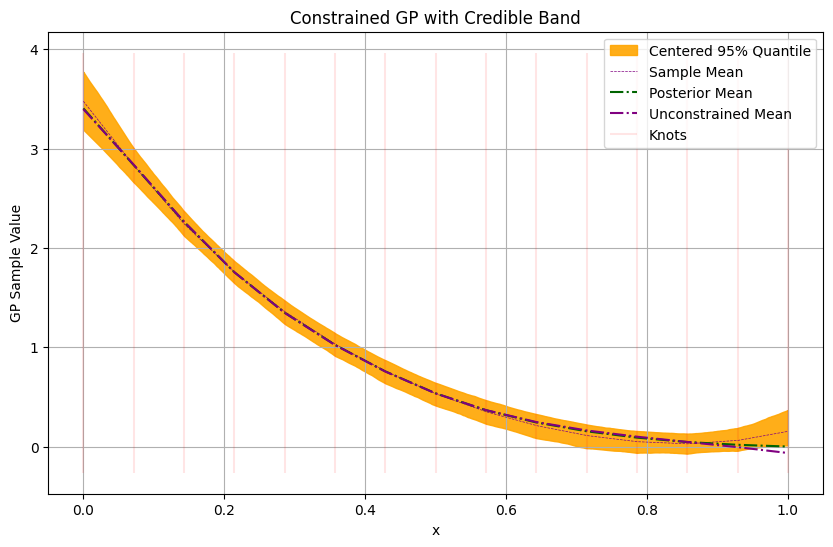

In [ ]:
import hamiltonianMonteCarlo as hmc
from constrained_gpr import ConstrainedGaussianProcess
from basis_functions import BasisFunctions as bf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
num_stab = 1

noise_std = 0.5


knots = [0,0.01,0.15,0.2, 0.5, 0.75, 1]
m = 15

X_train = np.linspace(0, 1, 50)
true_y = 4*np.exp(-X_train*4) 
noise_matrix = (np.eye(len(X_train)) * np.random.uniform(noise_std**2,0, len(X_train)     ) )  
y_train = true_y + np.random.multivariate_normal(mean = np.zeros(X_train.shape[0]), cov = noise_matrix)

#y_train[int(len(y_train)/2)] += 0.4
#y_train[-1] += -0.3

X_test = np.linspace(0, 1, 1000)
y_test = 4*np.exp(-X_test*4)

# ------------------------------ No constraints ------------------------------ #

# GPY torch to get kernel parameters.

from oldfiles.base_GP import trainGP



len_scale, out_scale, base_kernel = trainGP(X_train, y_train, noise_matrix, test_x= X_test)


#-------------------------------------------------


constrained_gp = ConstrainedGaussianProcess(m = m, noise=noise_matrix,
                                            kernel_params={'variance': out_scale, 'length_scale': len_scale})

constrained_gp.fit(X_train, y_train)
constrained_gp.plot_posterior_samples(X_test = X_test, y_test= y_test, numerical_stability=num_stab)

 # ----------------------------- Only Monotonicity ---------------------------- #

# Define general linear constraints
m_c = (m -1) + 1
Lambda = np.zeros((m_c , m))


# Enforce Monotonicity constraint
for i in range(m-1):
    Lambda[i, i] = +1
    Lambda[i, i + 1] = -1

Lambda[m_c - 1, -1] = 1

lower_bound = np.zeros(m_c) 
lower_bound[m-1] = 0

constrained_gp_mon = ConstrainedGaussianProcess(m = m, noise=noise_matrix, constraint_matrix=Lambda, 
                                                lower_bound= lower_bound,
                                                kernel_params={'variance': out_scale, 'length_scale': len_scale})
constrained_gp_mon.fit(X_train, y_train)

constrained_gp_mon.plot_posterior_samples(X_test = X_test, y_test= y_test, numerical_stability=num_stab)

 # ------------------------ Monotonicity and Convexity ------------------------ #

# m_c = (m -1) + (m-2) 
# Lambda = np.zeros((m_c, m))
# # Enforce Monotonicity constraint
# for i in range(m-1):
#     Lambda[i, i] = +1
#     Lambda[i, i + 1] = -1
# # Enforce convexity constraint
# for i in range(m-2):
#     Lambda[i + m-1, i] = +1
#     Lambda[i + m-1, i + 1] = -2
#     Lambda[i + m-1, i + 2] = +1

# # Lambda[m_c -1, :] = np.ones(m)

# lower_bound = np.zeros(m_c)
# # lower_bound[m-1 + m-2] = 0 

m_c = (m -2) + 2
Lambda = np.zeros((m_c, m))
# Enforce convexity constraint
for i in range(m-2):
    Lambda[i, i] = +1
    Lambda[i, i + 1] = -2
    Lambda[i, i + 2] = +1

Lambda[m_c -1, -1] = 1
Lambda[m_c -2, 1] = -1
lower_bound = np.zeros(m_c)
lower_bound[m-2] = -y_test[0]-3*np.sqrt(noise_matrix[0,0])

constrained_gp_moncon = ConstrainedGaussianProcess(m = m, noise=noise_matrix, constraint_matrix=Lambda,
                                            lower_bound= lower_bound,
                                            kernel_params={'variance': out_scale, 'length_scale': len_scale})
constrained_gp_moncon.fit(X_train, y_train)
constrained_gp_moncon.plot_posterior_samples(numerical_stability=num_stab, X_test=X_test)

C:\Users\Emre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gpytorch\likelihoods\noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iter 100/500 - Loss: -3.914
  lengthscale: 0.211
  outputscale: 0.016
Iter 200/500 - Loss: -3.915
  lengthscale: 0.208
  outputscale: 0.015
Iter 300/500 - Loss: -3.915
  lengthscale: 0.208
  outputscale: 0.015
Iter 400/500 - Loss: -3.915
  lengthscale: 0.208
  outputscale: 0.015
Iter 500/500 - Loss: -3.915
  lengthscale: 0.208
  outputscale: 0.015


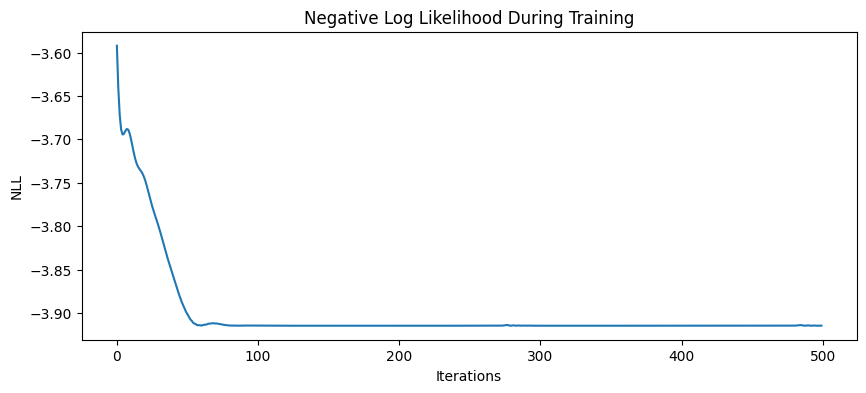

C:\Users\Emre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


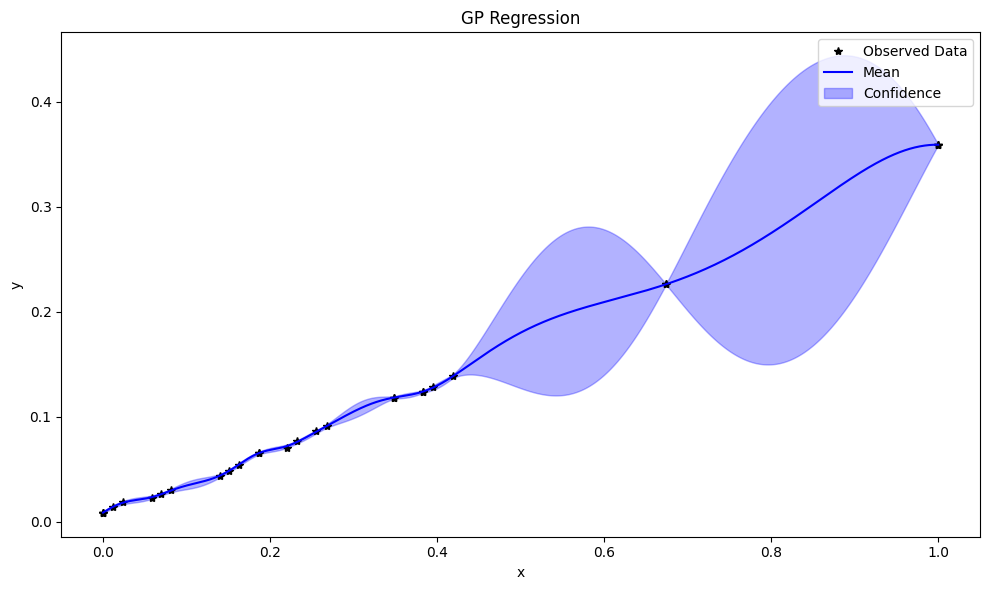

Final lengthscale: 0.2083
Final outputscale: 0.0150


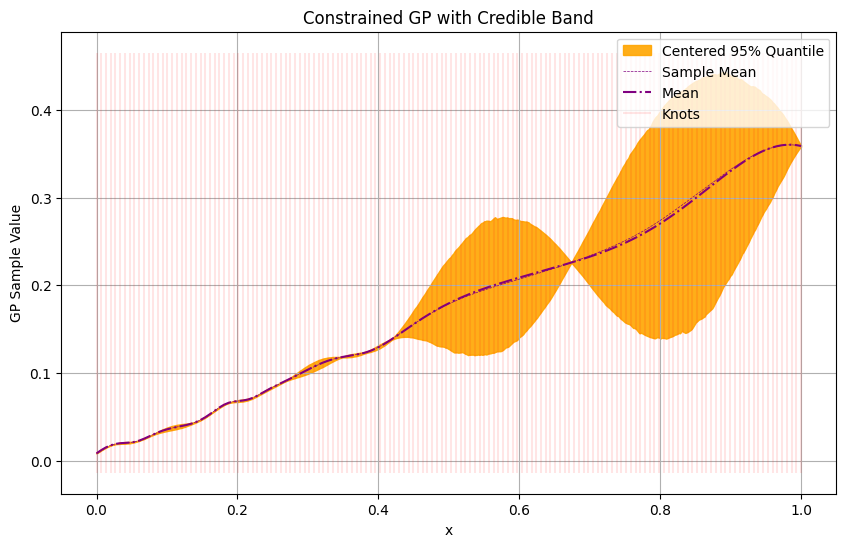

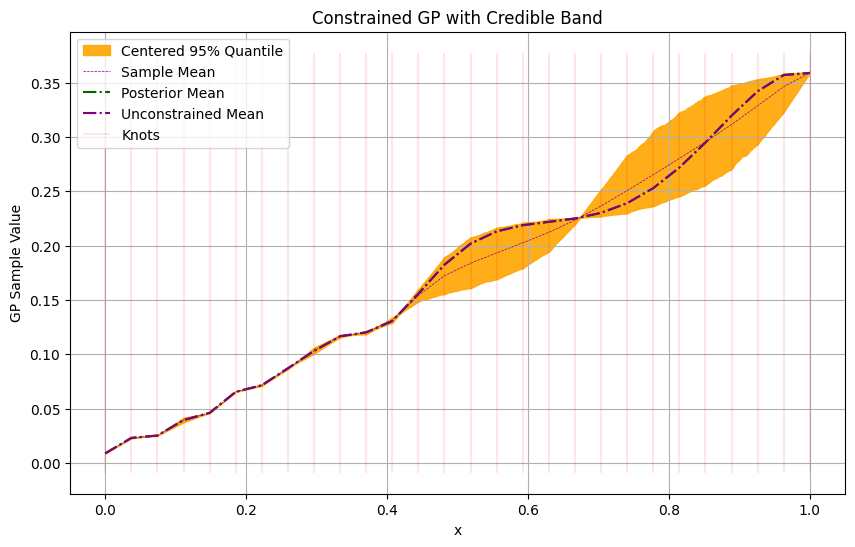

In [ ]:
import pandas as pd

quoteDateData = pd.read_csv('quoteDateData.csv', index_col= False)

maturities = quoteDateData['expiration'].unique()
strikes = quoteDateData['strike'].unique()

maturityData = quoteDateData[quoteDateData['strike'] == strikes[5]]
maturityData

c = 0.1
noise_total = ((maturityData['adj_ask_TIV']*100) - (maturityData['adj_bid_TIV']*100)).values**2 * c

X_total = maturityData['T'].values
X_total = (X_total - X_total.min())/ (X_total.max() - X_total.min())

sample_indices = np.random.choice(range(len(X_total)), int(len(X_total)/1.2), replace=False)
sample_indices = np.append(sample_indices, len(X_total)-1)
sample_indices = np.append(sample_indices, 0)

X_train = X_total[sample_indices]
X_true = X_total[~np.isin(X_total, X_train)]

noise = noise_total[sample_indices]
noise_test = noise_total[~np.isin(noise_total, noise)]

m = len(X_train)

y_true = maturityData['adj_mid_TIV'].values * 100
y_train = y_true[sample_indices]


noise_matrix = np.multiply(np.eye(len(X_train))  , noise   )
test_noise = np.multiply(np.eye(len(noise_test))  , noise_test   )

# ------------------------------ No constraints ------------------------------ #

# GPY torch to get kernel parameters.

from oldfiles.base_GP import trainGP

test_x = np.linspace(0, 1, 1000)

len_scale, out_scale, base_kernel = trainGP(X_train, y_train, noise_matrix, test_x = test_x)


#-------------------------------------------------


constrained_gp = ConstrainedGaussianProcess(m = 150, noise=noise_matrix,
                                            kernel_params={'variance': out_scale, 'length_scale': len_scale})

constrained_gp.fit(X_train, y_train)

X_test = np.linspace(0, 1, 1000)

constrained_gp.plot_posterior_samples(X_test= X_test)




 # ----------------------------- Only Monotonicity ---------------------------- #

# Define general linear constraints
Lambda = np.zeros(( (m -1)+1, m))

# Enforce Monotonicity constraint
for i in range(m-1):
    Lambda[i, i] = -1
    Lambda[i, i + 1] = +1

Lambda[m-1, :] = np.ones(m)

lower_bound = np.zeros(m) 
lower_bound[m-1] = 0

constrained_gp_mon = ConstrainedGaussianProcess(m = m, noise=noise_matrix, constraint_matrix=Lambda, 
                                                lower_bound= lower_bound,
                                                kernel_params={'variance': out_scale, 'length_scale': len_scale})
constrained_gp_mon.fit(X_train, y_train)
X_test = np.linspace(0, 1, 1000)

constrained_gp_mon.plot_posterior_samples(numerical_stability=num_stab, X_test= X_test)

Iter 100/500 - Loss: -2.601
  lengthscale: 0.677
  outputscale: 0.113
Iter 200/500 - Loss: -2.601
  lengthscale: 0.675
  outputscale: 0.112
Iter 300/500 - Loss: -2.601
  lengthscale: 0.675
  outputscale: 0.112
Iter 400/500 - Loss: -2.601
  lengthscale: 0.675
  outputscale: 0.112
Iter 500/500 - Loss: -2.601
  lengthscale: 0.675
  outputscale: 0.112


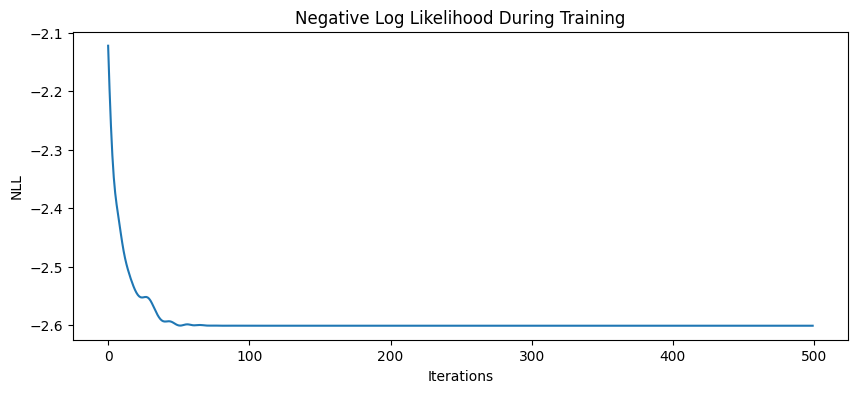

C:\Users\Emre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


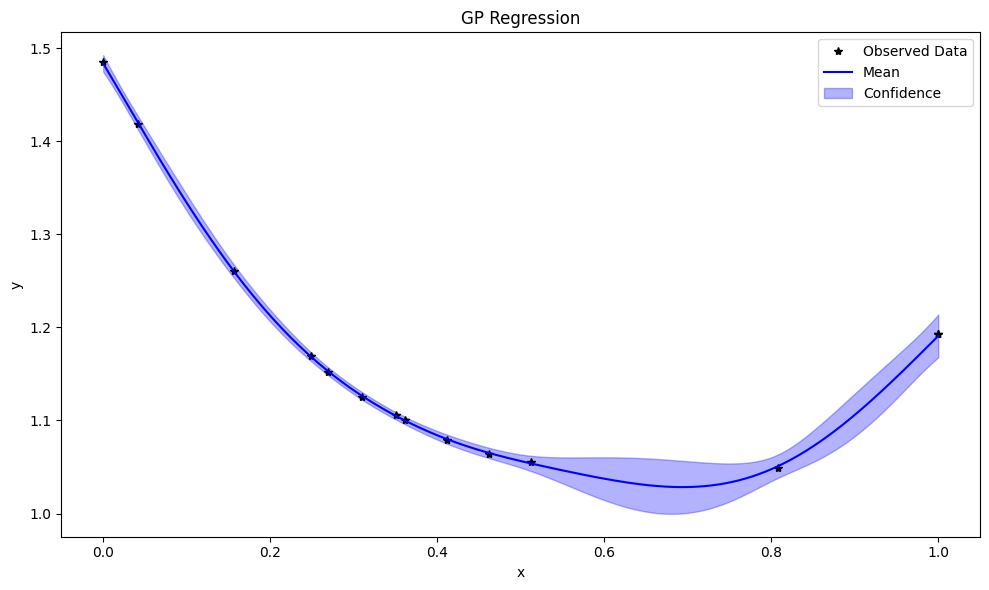

Final lengthscale: 0.6747
Final outputscale: 0.1119


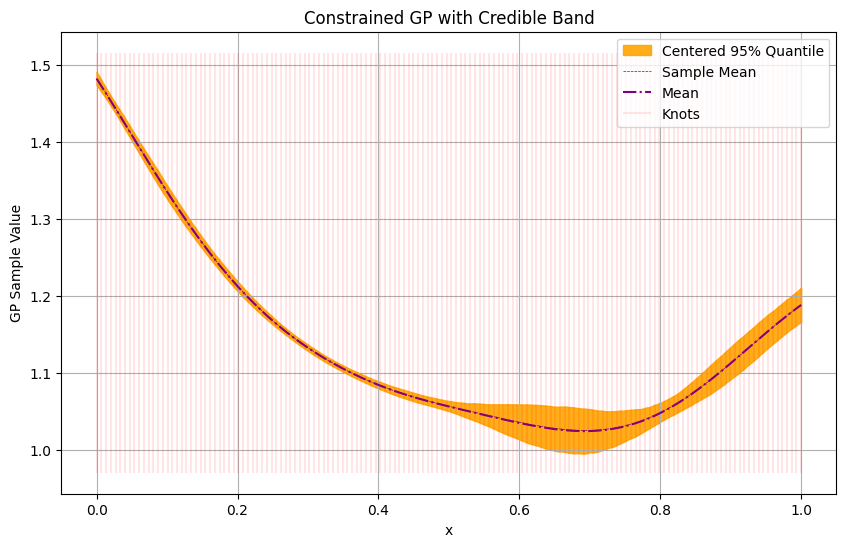

In [ ]:
import pandas as pd

quoteDateData = pd.read_csv('quoteDateData.csv', index_col= False)

maturities = quoteDateData['expiration'].unique()
strikes = quoteDateData['strike'].unique()

maturityData = quoteDateData[quoteDateData['expiration'] == maturities[20]]
maturityData = maturityData[maturityData['option_type'] == 'C']

c = 0.05
noise_total = ((1000*maturityData['ask_TIV']) - (1000*maturityData['bid_TIV'])).values**2 * c

X_total = maturityData['m'].values
X_total = (X_total - X_total.min())/ (X_total.max() - X_total.min())

sample_indices = np.random.choice(range(len(X_total)), int(len(X_total)/2), replace=False)
sample_indices = np.append(sample_indices, len(X_total)-1)
sample_indices = np.append(sample_indices, 0)

X_train = X_total[sample_indices]
X_true = X_total[~np.isin(X_total, X_train)]

noise = noise_total[sample_indices]
noise_test = noise_total[~np.isin(noise_total,noise)]

m = len(X_train)

y_true = 1000*maturityData['mid_TIV'].values
y_train = y_true[sample_indices]


noise_matrix = np.multiply(np.eye(len(X_train)), noise   )
test_noise = np.multiply(np.eye(len(X_true)), noise_test   )

# ------------------------------ No constraints ------------------------------ #

# GPY torch to get kernel parameters.

from oldfiles.base_GP import trainGP

test_x = np.linspace(0, 1, 1000)

len_scale, out_scale, base_kernel = trainGP(X_train, y_train, noise_matrix, test_x = X_test)


#-------------------------------------------------


constrained_gp = ConstrainedGaussianProcess(m = 150, noise=noise_matrix,
                                            kernel_params={'variance': out_scale, 'length_scale': len_scale})

constrained_gp.fit(X_train, y_train)

X_test = np.linspace(0, 1, 1000)

constrained_gp.plot_posterior_samples(X_test= X_test)

In [10]:
X_total = maturityData['m'].values

knots_moneyness = constrained_gp.basis.knots[0]* (X_total.max() - X_total.min()) + X_total.min()
samples = constrained_gp.posterior_samples


def constraint_components(sample,knots):

    first_derivative = sample[1:] - sample[:-1]
    second_derivative = first_derivative[1:] - first_derivative[:-1]

    first_terms = []
    second_terms = []
    third_terms = []

    for i in range(2,len(knots)-2):
        
        if i == 0 or i == len(knots)-2:
            continue
        else:
            first_term = 1 - (knots[i] * first_derivative[i-1] / 2*sample[i-1] )**2
            second_term = - first_derivative[i-1]/4 * (1/sample[i]+ 1/4)
            third_term = second_derivative[i-2]/2

            first_terms.append(first_term)
            second_terms.append(second_term)
            third_terms.append(third_term)

    return first_terms, second_terms, third_terms


first_components = [constraint_components(sample, knots_moneyness)[0] for sample in samples]

first_components = np.array(first_components)

second_components = [constraint_components(sample, knots_moneyness)[1] for sample in samples]

second_components = np.array(second_components)

third_components = [constraint_components(sample, knots_moneyness)[2] for sample in samples]

third_components = np.array(third_components)




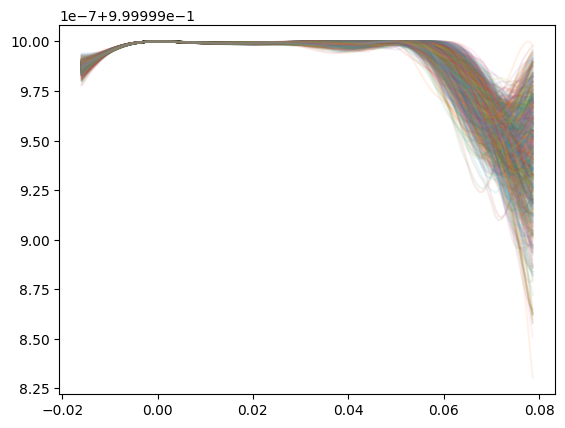

In [9]:
for i in range(third_components.shape[0]):
    plt.plot(knots_moneyness[2:-2], first_components[i], alpha=0.1)

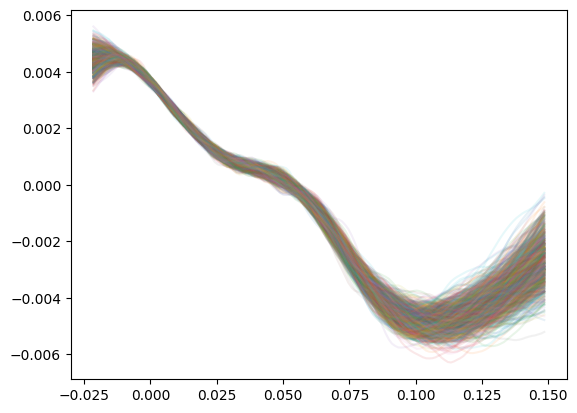

In [44]:
for i in range(third_components.shape[0]):
    plt.plot(knots_moneyness[2:-2], second_components[i], alpha=0.1)

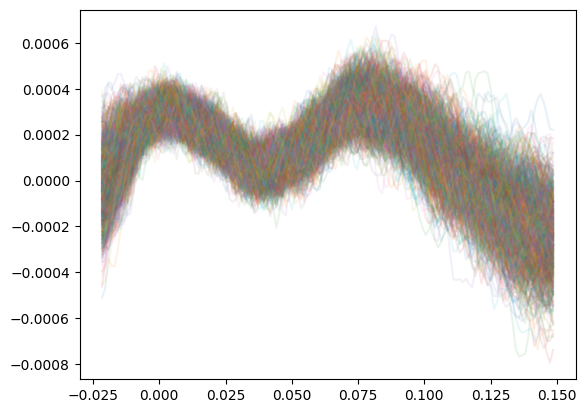

In [42]:
for i in range(third_components.shape[0]):
    plt.plot(knots_moneyness[2:-2], third_components[i], alpha=0.1)


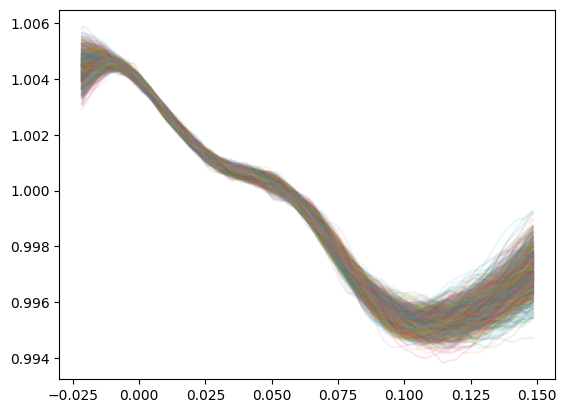

In [46]:
total = first_components + second_components + third_components

for i in range(total.shape[0]):
    plt.plot(knots_moneyness[2:-2], total[i], alpha=0.1)

# Sampling Trials

In [ ]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt

def truncated_multivariate_normal(A, l=None, u=None, num_samples=1000):
    """
    Generate samples from a truncated multivariate normal distribution
    using the Minimax Tilting method.
    
    Parameters:
    A : ndarray (m x d)
        Constraint matrix
    l : ndarray (m,) or None
        Lower bound constraints (optional)
    u : ndarray (m,) or None
        Upper bound constraints (optional)
    num_samples : int
        Number of samples to generate
    
    Returns:
    samples : ndarray (num_samples x d)
        Generated samples from the truncated normal distribution
    """
    m, d = A.shape
    
    if l is None:
        l = -np.inf * np.ones(m)
    if u is None:
        u = np.inf * np.ones(m)
    
    # Compute Cholesky decomposition of A A^T to handle rectangular A
    Sigma = np.linalg.inv(A @ A.T + 1e-6 * np.eye(m))  # Compute covariance structure
    L = np.linalg.cholesky(Sigma)  # Cholesky factor
    
    # Function to optimize for Minimax Tilting
    def tilting_objective(mu):
        """Minimax optimization objective function."""
        mu_tilted = L @ mu[:m]  # Ensure correct shape alignment
        psi = -np.dot(mu_tilted, mu_tilted)/2 + np.sum(np.log(stats.norm.cdf(u - mu_tilted) - 
                                                              stats.norm.cdf(l - mu_tilted)))
        return -psi  # Minimize the negative
    
    # Solve for the optimal tilting parameter
    mu0 = np.zeros(m)  # Correct dimension
    res = opt.minimize(tilting_objective, mu0, method='L-BFGS-B')
    mu_star = res.x
    
    # Sampling from importance distribution
    def importance_sampler():
        """Generate one sample from the tilted importance distribution."""
        z = np.random.randn(m)
        x = np.linalg.lstsq(A, L @ z + mu_star, rcond=None)[0]  # Solve for x
        return x if np.all(l <= A @ x) and np.all(A @ x <= u) else None  # Enforce constraints
    
    # Accept-Reject Sampling
    samples = []
    while len(samples) < num_samples:
        x = importance_sampler()
        if x is not None:
            accept_prob = np.exp(-np.dot(x, x)/2 + np.dot(A.T @ mu_star, x))
            if np.random.uniform() < accept_prob:
                samples.append(x)
    
    return np.array(samples)

# Example usage
d = 5  # Dimension
m = 3  # Constraints
A = constrained_gp_moncon.constraint_matrix
l = constrained_gp_moncon.lower_bound
#u = np.random.uniform(0, 1, m)

samples = truncated_multivariate_normal(A, l=l, u=u, num_samples=1000)
print(samples[:5])  # Show first few samples

Made changes.

In [31]:
m = A.shape[0]
Sigma = np.linalg.inv(A @ A.T + 1e-6 * np.eye(m))  # Compute covariance structure
L = np.linalg.cholesky(Sigma)  # Cholesky factor
L.shape

(98, 98)

In [6]:
import numpy as np

def sample_truncated_normal_rsm(mu, Sigma, lower, upper, n_samples=1):
    """
    Sample from a truncated multivariate normal N(mu, Sigma) restricted to the region defined by lower <= x <= upper 
    (element-wise bounds), using the Rejection Sampling from the Mode (RSM) method&#8203;:contentReference[oaicite:6]{index=6}.
    
    Parameters:
        mu (array_like): Mean vector of the multivariate normal (length p).
        Sigma (array_like): Covariance matrix (p x p), positive-definite.
        lower (array_like or float): Lower bounds for each dimension. Use -np.inf for no lower bound on a dimension.
        upper (array_like or float): Upper bounds for each dimension. Use np.inf for no upper bound on a dimension.
        n_samples (int): Number of random samples to generate (default is 1).
    
    Returns:
        numpy.ndarray: Array of shape (n_samples, p) containing samples drawn from the truncated normal distribution.
    
    The algorithm:
    1. **Check mean position**: If the mean `mu` lies inside the feasible region, use naive rejection (sample from N(mu, Σ) and accept those in bounds)&#8203;:contentReference[oaicite:7]{index=7}.
    2. **Find the mode μ***: If `mu` is outside, compute μ* = argmin_{x in region} (x - mu)^T Σ^{-1} (x - mu), the point in the region with highest density (the mode of the truncated normal). This is solved via a convex quadratic program (here using an active-set method for box constraints).
    3. **Two-stage rejection sampling**: Use μ* as the center of a proposal distribution:
       - **Inner loop**: Generate a candidate y ~ N(μ*, Σ) and reject it if y is outside the region (this yields samples from the truncated normal q with mean μ*).
       - **Outer loop**: Accept the candidate y with probability `A = f(y)/q(y)` (the ratio of target to proposal density at y). Since both f and q are Gaussian (with same Σ), `A = exp(-0.5 * [ (y-μ)^T Σ^{-1} (y-μ) - (y-μ*)^T Σ^{-1} (y-μ*) ])`. If y is not accepted, repeat the process.
    This procedure produces independent samples from the target truncated normal&#8203;:contentReference[oaicite:8]{index=8}.
    """
    mu = np.asarray(mu, dtype=float)
    Sigma = np.asarray(Sigma, dtype=float)
    p = mu.shape[0]
    assert Sigma.shape == (p, p), "Covariance matrix must be shape (p,p)"
    # Convert bounds to arrays of length p
    lower = np.full(p, -np.inf) if np.isscalar(lower) else np.asarray(lower, dtype=float)
    upper = np.full(p,  np.inf) if np.isscalar(upper) else np.asarray(upper, dtype=float)
    assert lower.shape[0] == p and upper.shape[0] == p, "Bounds must be scalars or length-p arrays"
    
    # Helper to check if a point x lies within bounds
    def in_region(x):
        return np.all(x >= lower) and np.all(x <= upper)
    
    # 1. If mu is inside region, do naive rejection sampling
    if in_region(mu):
        samples = []
        while len(samples) < n_samples:
            x = np.random.multivariate_normal(mu, Sigma)
            if in_region(x):
                samples.append(x)
        return np.array(samples)
    
    # 2. Compute mode x* of the truncated normal (point in region with highest density)
    M = np.linalg.inv(Sigma)  # inverse covariance for distance calculations
    # Initialize x* by clamping mu to the feasible region bounds (nearest feasible point)
    x_star = mu.copy()
    active_lower = set()  # indices at lower bound
    active_upper = set()  # indices at upper bound
    free_set = set(range(p))  # indices not fixed at a bound
    for i in range(p):
        if x_star[i] < lower[i]:
            x_star[i] = lower[i]
            active_lower.add(i)
            free_set.discard(i)
        elif x_star[i] > upper[i]:
            x_star[i] = upper[i]
            active_upper.add(i)
            free_set.discard(i)
    # Active-set iterations: adjust x_star until optimal
    while True:
        # Solve for free variables (those not at bounds) by setting gradient=0 for those components
        if free_set:
            F = np.array(sorted(free_set))
            B = np.array(sorted(set(range(p)) - free_set))
            # Submatrices of M for free (F) and bound (B) indices
            M_FF = M[np.ix_(F, F)]
            M_FB = M[np.ix_(F, B)]
            # Solve M_FF * (x_F - mu_F) = - M_FB * (x_B - mu_B)
            rhs = - M_FB.dot(x_star[B] - mu[B])
            # Compute the step for free variables
            delta_xF = np.linalg.solve(M_FF, rhs)
            x_star[F] = mu[F] + delta_xF
        # Compute gradient of objective at x_star: grad = M * (x_star - mu)
        grad = M.dot(x_star - mu)
        # Check for bound violations or inactive constraints that should be active
        set_changed = False
        # If any free coordinate violates bounds, enforce that bound (make it active)
        for i in list(free_set):
            if x_star[i] < lower[i] - 1e-12:
                x_star[i] = lower[i]
                active_lower.add(i); free_set.remove(i); set_changed = True
            elif x_star[i] > upper[i] + 1e-12:
                x_star[i] = upper[i]
                active_upper.add(i); free_set.remove(i); set_changed = True
        # If any active bound has a non-satisfied optimality condition (gradient sign), free it
        for i in list(active_lower):
            if grad[i] < 0:  # gradient should be >= 0 at lower bound
                active_lower.remove(i); free_set.add(i); set_changed = True
        for i in list(active_upper):
            if grad[i] > 0:  # gradient should be <= 0 at upper bound
                active_upper.remove(i); free_set.add(i); set_changed = True
        if not set_changed:
            break  # optimal x_star found
    # 3. Rejection sampling using N(x_star, Sigma) as proposal
    samples = []
    while len(samples) < n_samples:
        # Inner loop: draw from proposal q (truncated N(x_star, Σ))
        while True:
            y = np.random.multivariate_normal(x_star, Sigma)
            if in_region(y):
                break
        # Compute acceptance probability A = exp(-0.5 * [ (y-mu)^T M (y-mu) - (y-x_star)^T M (y-x_star) ])
        diff = (y - mu).dot(M).dot(y - mu) - (y - x_star).dot(M).dot(y - x_star)
        accept_prob = np.exp(-0.5 * diff)
        if accept_prob >= 1 or np.random.rand() < accept_prob:  # accept (cap ratio at 1 if numerical issues)
            samples.append(y)
    return np.array(samples)

mu = [ -1.0, -2.0 ]               # mean (outside the region)
Sigma = [[1.0, 0.3],[0.3, 1.0]]   # covariance matrix
samples = sample_truncated_normal_rsm(mu, Sigma, lower=[0,0], upper=[np.inf, np.inf], n_samples=1000)



In [ ]:
self = constrained_gp_moncon
numerical_stability = 10e-6


mean_eta =  Lambda @ self.mu
cov_eta =  ( Lambda @ self.Sigma @ Lambda.T ) * numerical_stability*np.eye(len(mean_eta))

lower_bounds = numerical_stability * (self.lower_bound if self.lower_bound is not None else -np.inf * np.ones_like(mean_eta))
upper_bounds = numerical_stability * (self.upper_bound if self.upper_bound is not None else np.inf * np.ones_like(mean_eta))

#Calculate v*
nu_star = Lambda @ self.mu_star

eta_samples = sample_truncated_normal_rsm(mean_eta, cov_eta, lower_bounds, upper_bounds, n_samples=10)

In [ ]:
# Sample η using HMC
eta_samples = hmc.sample(mu= mean_eta, Sigma=cov_eta, a=lower_bounds, b=upper_bounds, num_samples=num_samples, x_init=nu_star)

# Solve for ξ using Λξ = η

eta_samples = eta_samples.T / numerical_stability
xi_samples = np.linalg.pinv(Lambda) @ eta_samples

self.posterior_samples = xi_samples.T
self.eta_samples = eta_samples 

Iter 100/500 - Loss: -0.676
  lengthscale: 0.345
  outputscale: 0.193
Iter 200/500 - Loss: -0.676
  lengthscale: 0.342
  outputscale: 0.190
Iter 300/500 - Loss: -0.676
  lengthscale: 0.342
  outputscale: 0.190
Iter 400/500 - Loss: -0.676
  lengthscale: 0.342
  outputscale: 0.190
Iter 500/500 - Loss: -0.676
  lengthscale: 0.342
  outputscale: 0.190


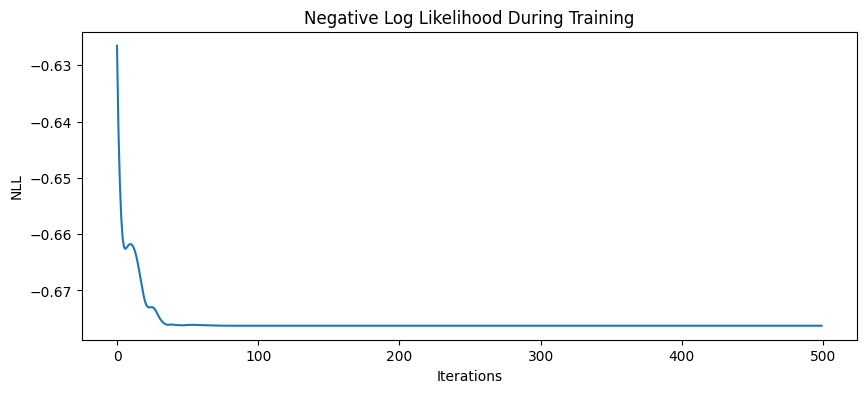

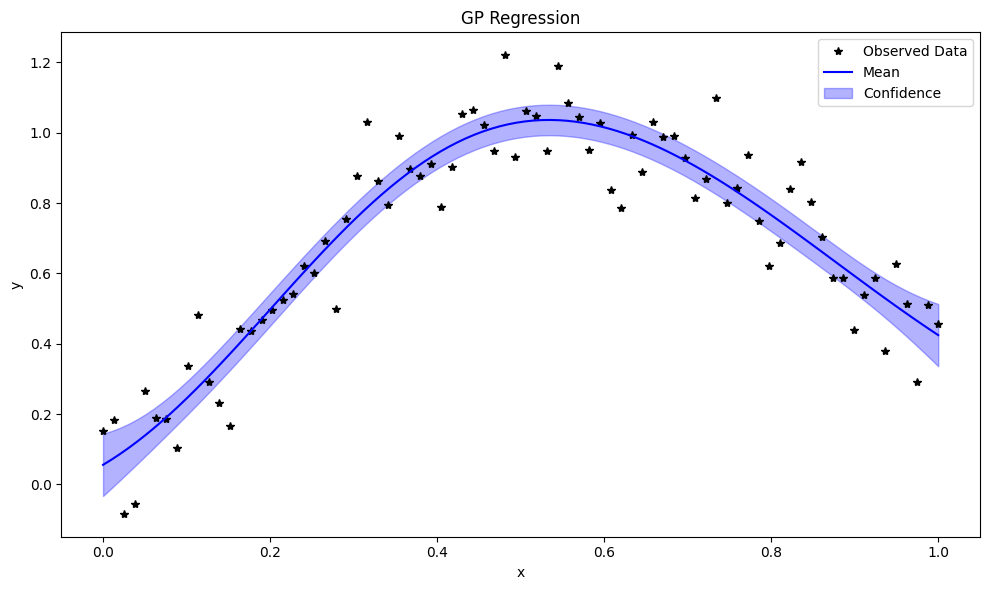

Final lengthscale: 0.3420
Final outputscale: 0.1902


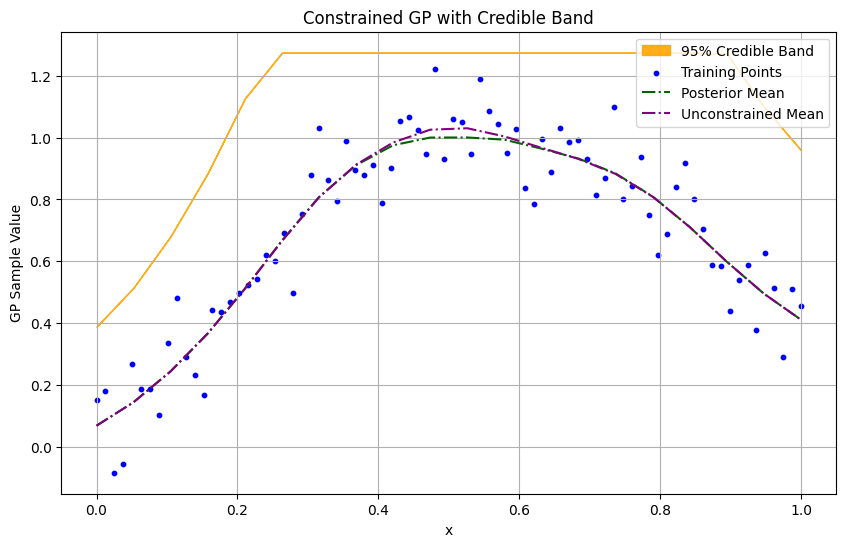

In [39]:
knots = np.linspace(0, 1, 20)  # Define knot locations
num_of_knots = len(knots)

noise_std = 1*10**-1

X_train = np.linspace(0, 1, 80) 
y_train = np.sin(X_train*np.pi*0.9) +  np.random.normal(scale= noise_std ,size=len(X_train))  # Convex function: f(x) = x^2

noise_matrix = noise_std**2 * np.eye(len(X_train))

# Define boundedness constraints
Lambda = np.eye(num_of_knots)
Lambda = np.append(Lambda, np.ones((1, num_of_knots)), axis=0)
lower_bound = np.zeros(num_of_knots+1)
lower_bound[-1] = -50
upper_bound = np.ones(num_of_knots+1)
upper_bound[-1] = 50

len_scale, out_scale = trainGP(X_train, y_train, noise_matrix)

constrained_gp = ConstrainedGaussianProcess(knots = knots, noise=noise_matrix, constraint_matrix=Lambda,
                                            lower_bound=lower_bound, upper_bound=upper_bound,
                                            kernel_params={'variance': out_scale, 'length_scale': len_scale})
                                             
constrained_gp.fit(X_train, y_train)

# Plot posterior samples
constrained_gp.plot_posterior_samples()

In [14]:
knots = np.linspace(0, 1, 10)  # Define knot locations
num_of_knots = len(knots)

noise_std = 2*10**-1

X_train = np.linspace(0, 1, 35)  
y_train = np.log(X_train+0.5) + 0.05 * np.random.normal(size=len(X_train), scale= noise_std)  # Concave function: f(x) = -log(x)
noise_matrix = noise_std**2 * np.diag(np.ones_like(X_train))  # Small observation noise

k = 1

Lambda = np.zeros((len(knots) , len(knots)))

for i in range(len(knots) - 2):
    Lambda[i, i] = -1
    Lambda[i, i + 1] = +1
    Lambda[i, i + 2] = -1
lower_bound = np.zeros(len(knots))  # Enforce convexity constraint

constrained_gp = ConstrainedGaussianProcess(knots = knots, noise=noise_matrix, constraint_matrix=Lambda, lower_bound=lower_bound)

constrained_gp.fit(X_train, y_train)

# Plot posterior samples
constrained_gp.plot_posterior_samples(num_samples=1000)

KeyboardInterrupt: 

## 2-Dimensional Examples

In [16]:
import hamiltonianMonteCarlo as hmc
from constrained_gpr import ConstrainedGaussianProcess
from basis_functions import BasisFunctions as bf
from matplotlib import pyplot as plt
import numpy as np

mm = [10,10]
noise_matrix = np.eye(np.prod(mm)) * 5*10e-3

constrained_gp = ConstrainedGaussianProcess(m = mm, noise=noise_matrix)


x, y = np.meshgrid(np.linspace(0, 1, 15), np.linspace(0, 1, 15))
x = x.T.flatten().tolist()
y = y.T.flatten().tolist()
X_train = [x, y]
y_train = np.zeros(len(X_train[0]))
for i_0 in range(len(X_train[0])):
        y_train[i_0] = np.exp(-0.3*((X_train[0][i_0]-0.5)**2 + (X_train[1][i_0] - 0.5 )**2)) + np.random.normal(0, 10e-3, 1)

noise_matrix = np.eye(len(y_train)) * 5*10e-3


# Define general linear constraints

m = np.prod(mm)
Lambda = np.zeros(( (m -1), m))

# Enforce Monotonicity constraint
for i in range(m-1):
    Lambda[i, i] = +1
    Lambda[i, i + 1] = -1


lower_bound = np.zeros(m-1) 

# ------------------------------ No constraints ------------------------------ #
constrained_gp = ConstrainedGaussianProcess(m = mm, noise=noise_matrix)
constrained_gp.fit(X_train, y_train)
 #constrained_gp.plot_posterior_samples()

 # ----------------------------- Only Monotonicity ---------------------------- #
constrained_gp = ConstrainedGaussianProcess(m = mm, noise=noise_matrix, constraint_matrix=Lambda, 
                                            lower_bound= lower_bound)
constrained_gp.fit(X_train, y_train)

#constrained_gp.plot_posterior_samples()
 
 # ------------------------ Monotonicity and Convexity ------------------------ #

m = np.prod(mm)
Lambda = np.zeros(( (m -1) + (m-2), m))
# Enforce Monotonicity constraint
for i in range(m-1):
    Lambda[i, i] = +1
    Lambda[i, i + 1] = -1
# Enforce convexity constraint
for i in range(m-2):
    Lambda[i + m-1, i] = +1
    Lambda[i + m-1, i + 1] = -2
    Lambda[i + m-1, i + 2] = +1

lower_bound = np.zeros(m-1 + m-2) 


constrained_gp = ConstrainedGaussianProcess(m = mm, noise=noise_matrix, constraint_matrix=Lambda,
                                            lower_bound= lower_bound)
constrained_gp.fit(X_train, y_train)
#constrained_gp.plot_posterior_samples() 

C:\Users\Emre\AppData\Local\Temp\ipykernel_6100\2394325170.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train[i_0] = np.exp(-0.3*((X_train[0][i_0]-0.5)**2 + (X_train[1][i_0] - 0.5 )**2)) + np.random.normal(0, 10e-3, 1)


(array([0.79239306, 0.83442037, 0.86577619, 0.88638474, 0.88711734,
        0.89137729, 0.87549789, 0.86832727, 0.85601255, 0.79914893,
        0.851092  , 0.88738062, 0.89388041, 0.92270895, 0.92152644,
        0.9159629 , 0.93535483, 0.90209352, 0.87809347, 0.85319903,
        0.8751144 , 0.89724239, 0.92531133, 0.93831039, 0.94452519,
        0.93923105, 0.94422318, 0.91899188, 0.91814195, 0.86092584,
        0.86172518, 0.90860878, 0.91981323, 0.94419744, 0.9521193 ,
        0.96111986, 0.93437577, 0.9340344 , 0.90708683, 0.86943758,
        0.89088934, 0.91487729, 0.9425812 , 0.96616375, 0.97643369,
        0.97815255, 0.95463186, 0.94880551, 0.92389168, 0.88456185,
        0.89660417, 0.92807921, 0.94718818, 0.96507861, 0.96620071,
        0.98430792, 0.96493213, 0.9500514 , 0.91288326, 0.89460934,
        0.88725827, 0.91168403, 0.93218489, 0.93878486, 0.94788139,
        0.95506652, 0.93632034, 0.93645783, 0.9115031 , 0.87284078,
        0.85729448, 0.90591742, 0.93600521, 0.93

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x, y=y, z=y_train, 
                                       mode='markers', marker=dict(size=4, color='green'), name='Test Points'))

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def plot_posterior_samples_2d(self, X_test=None, y_test=None, num_samples=100, use_plotly=True):
    """
    Plot the posterior mean with 95% confidence bands from the constrained GP in 2D.
    """
    if self.posterior_samples is None:
        self.posterior_samples = self.sample_posterior(num_samples)
    
    X, Y = np.meshgrid(self.basis.knots[0], self.basis.knots[1])
    posterior_samples_np = np.array(self.posterior_samples)
    
    # Compute posterior mean and 95% confidence interval
    Z_mean = np.mean(posterior_samples_np, axis=0).reshape(X.shape)
    Z_lower = np.percentile(posterior_samples_np, 2.5, axis=0).reshape(X.shape)
    Z_upper = np.percentile(posterior_samples_np, 97.5, axis=0).reshape(X.shape)
    
    if use_plotly:
        fig = go.Figure()
        
        # Plot posterior mean
        fig.add_trace(go.Surface(z=Z_mean, x=X, y=Y, colorscale='Viridis', opacity=0.9, name='Posterior Mean'))
        
        # Plot confidence interval as semi-transparent layers
        fig.add_trace(go.Surface(z=Z_lower, x=X, y=Y, colorscale='Blues', opacity=0.3, name='Lower Bound'))
        fig.add_trace(go.Surface(z=Z_upper, x=X, y=Y, colorscale='Reds', opacity=0.3, name='Upper Bound'))
        
        # Plot training points
        x_train_np = np.array(self.x_train)
        y_train_np = np.array(self.y_train)
        fig.add_trace(go.Scatter3d(x=x_train_np[:, 0], y=x_train_np[:, 1], z=y_train_np, 
                                   mode='markers', marker=dict(size=3, color='blue'), name='Training Points'))
        
        # Plot test points if provided
        if X_test is not None and y_test is not None:
            X_test_np = np.array(X_test)
            y_test_np = np.array(y_test)
            fig.add_trace(go.Scatter3d(x=X_test_np[:, 0], y=X_test_np[:, 1], z=y_test_np, 
                                       mode='markers', marker=dict(size=4, color='green'), name='Test Points'))
        
        fig.update_layout(title='Posterior Mean with 95% Confidence Bands',
                          scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='GP Sample Value'))
        fig.show()
    else:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot posterior mean
        ax.plot_surface(X, Y, Z_mean, cmap='viridis', alpha=0.9, label='Posterior Mean')
        
        # Plot confidence interval
        ax.plot_surface(X, Y, Z_lower, cmap='Blues', alpha=0.3, label='Lower Bound')
        ax.plot_surface(X, Y, Z_upper, cmap='Reds', alpha=0.3, label='Upper Bound')
        
        # Plot training points
        x_train_np = np.array(self.x_train)
        y_train_np = np.array(self.y_train)
        ax.scatter(x_train_np[:, 0], x_train_np[:, 1], y_train_np, color='blue', label='Training Points', s=10)
        
        # Plot test points if provided
        if X_test is not None and y_test is not None:
            X_test_np = np.array(X_test)
            y_test_np = np.array(y_test)
            ax.scatter(X_test_np[:, 0], X_test_np[:, 1], y_test_np, color='green', label='Test Points')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('GP Sample Value')
        ax.set_title('Posterior Mean with 95% Confidence Bands')
        plt.legend()
        plt.show()


In [21]:
plot_posterior_samples_2d(constrained_gp, num_samples=10)